In [ ]:
!pip install numpy==1.16.1
import numpy as np
print(np.__version__)

1.16.1


In [ ]:
#TF 2.1 and torchaudio

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
!pip install soundfile                   
!pip install --no-deps torchaudio==0.5.0

     |████████████████████████████████| 3.2MB 5.2MB/s 


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import torch
import torch_xla
import torch_xla.core.xla_model as xm

ModuleNotFoundError: ignored

In [ ]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output,Audio
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython
from keras.models import load_model
import sys
import os
py_file_location = "/content/drive/My Drive/include"
sys.path.append(os.path.abspath(py_file_location))
import helpers

In [ ]:
#Hyperparameters

hop=192               
sr=16000             
min_level_db=-100    
ref_level_db=20

shape=24                        
vec_len=128           
bs = 64               
delta = 2.            

In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.)
melfunc = melobj.forward

def melspecfunc(waveform):
  specgram = specfunc(waveform)
  mel_specgram = melfunc(specgram)
  return mel_specgram

def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003):

    spec = torch.Tensor(spec)
    samples = (spec.shape[-1]*hop)-hop

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
  return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def prep(wv,hop=192):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
  S = librosa.power_to_db(S)-ref_level_db
  return normalize(S)

def deprep(S):
  S = denormalize(S)+ref_level_db
  S = librosa.db_to_power(S)
  wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8)
  return np.array(np.squeeze(wv))

In [ ]:
#Helper functions

#spectrograms from waveform array
def tospec(data):
  specs=np.empty(data.shape[0], dtype=object)
  for i in range(data.shape[0]):
    x = data[i]
    S=prep(x)
    S = np.array(S, dtype=np.float32)
    specs[i]=np.expand_dims(S, -1)
  print(specs.shape)
  return specs

#multiple spectrograms with a determined length from single wav file
def tospeclong(path, length=4*16000):
  x, sr = librosa.load(path,sr=16000)
  x,_ = librosa.effects.trim(x)
  loudls = librosa.effects.split(x, top_db=50)
  xls = np.array([])
  for interv in loudls:
    xls = np.concatenate((xls,x[interv[0]:interv[1]]))
  x = xls
  num = x.shape[0]//length
  specs=np.empty(num, dtype=object)
  for i in range(num-1):
    a = x[i*length:(i+1)*length]
    S = prep(a)
    S = np.array(S, dtype=np.float32)
    try:
      sh = S.shape
      specs[i]=S
    except AttributeError:
      print('spectrogram failed')
  print(specs.shape)
  return specs

#Waveform array from path 
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  count=0;
  for i in range(8000):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)
    adata.append(x)
    print(count)
    count+=1
  return np.array(adata)

#Concatenate spectrograms
def testass(a):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  return np.squeeze(con)

#Split spectrograms in chunks with equal size
def splitcut(data):
  ls = []
  mini = 0
  minifinal = 10*shape                                                              #max spectrogram length
  for i in range(data.shape[0]-1):
    if data[i].shape[1]<=data[i+1].shape[1]:
      mini = data[i].shape[1]
    else:
      mini = data[i+1].shape[1]
    if mini>=3*shape and mini<minifinal:
      minifinal = mini
  for i in range(data.shape[0]):
    x = data[i]
    if x.shape[1]>=3*shape:
      for n in range(x.shape[1]//minifinal):
        ls.append(x[:,n*minifinal:n*minifinal+minifinal,:])
      ls.append(x[:,-minifinal:,:])
  return np.array(ls)

In [ ]:
#Mel-Spectrogram
#adata: source spectrograms
#bdata: target spectrograms

#
awv=np.load("/content/drive/My Drive/noisyfull.npy")
#awv = audio_array('/content/drive/My Drive/PROJECT/noisy_trainset_28spk_wav')                          
aspec = tospec(awv)                                                                 
adata = splitcut(aspec) 
                                                        
#
bwv=np.load("/content/drive/My Drive/cleannfull.npy")
#bwv = audio_array('/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav')
bspec = tospec(bwv)
bdata = splitcut(bspec)


(11572,)
(11572,)


In [ ]:
from numpy import savetxt
from numpy import asarray
# define data
data = awv
#data = bwv
# save to csv file
savetxt('/content/data/datanoisy.csv', data, delimiter=',')

TypeError: ignored

In [ ]:
print(len(awv))
print(len(awv[0]))
print(awv)

11572
36534
[array([[-0.02322388],
       [-0.0375061 ],
       [-0.03912354],
       ...,
       [ 0.07904053],
       [ 0.06820679],
       [ 0.06991577]], dtype=float32)
 array([[ 0.05249023],
       [ 0.07910156],
       [ 0.099823  ],
       ...,
       [-0.06344604],
       [-0.08041382],
       [-0.10229492]], dtype=float32)
 array([[0.04006958],
       [0.03112793],
       [0.00750732],
       ...,
       [0.05047607],
       [0.03192139],
       [0.0151062 ]], dtype=float32)
 ...
 array([[-0.01797485],
       [-0.0267334 ],
       [-0.02606201],
       ...,
       [ 0.01348877],
       [ 0.02212524],
       [ 0.02328491]], dtype=float32)
 array([[ 0.05285645],
       [ 0.01400757],
       [-0.00762939],
       ...,
       [ 0.02770996],
       [ 0.00744629],
       [ 0.04553223]], dtype=float32)
 array([[ 0.02182007],
       [ 0.02627563],
       [ 0.04501343],
       ...,
       [-0.00463867],
       [-0.00546265],
       [-0.0005188 ]], dtype=float32)]


In [ ]:
#!pip install numpy==1.16.1
import numpy as np
print(np.__version__)
np.save("/content/drive/My Drive/cleann8k",bwv)

1.18.5


NameError: ignored

In [ ]:
bwv=np.load("/content/drive/My Drive/cleann8k.npy")
print(len(bwv))
print(len(bwv[0]))
print(bwv)

8000
42223
[array([[-0.00726318],
       [-0.00692749],
       [-0.00708008],
       ...,
       [-0.00518799],
       [-0.00527954],
       [-0.00567627]], dtype=float32)
 array([[ 0.00177002],
       [ 0.00146484],
       [ 0.00161743],
       ...,
       [-0.00283813],
       [-0.00271606],
       [-0.00167847]], dtype=float32)
 array([[0.00125122],
       [0.0010376 ],
       [0.00115967],
       ...,
       [0.00064087],
       [0.00048828],
       [0.00061035]], dtype=float32)
 ...
 array([[-0.00076294],
       [-0.00076294],
       [-0.00088501],
       ...,
       [ 0.00222778],
       [ 0.00180054],
       [ 0.00219727]], dtype=float32)
 array([[0.00219727],
       [0.00201416],
       [0.00143433],
       ...,
       [0.00094604],
       [0.00253296],
       [0.00500488]], dtype=float32)
 array([[-0.00320435],
       [-0.00357056],
       [-0.00030518],
       ...,
       [-0.00131226],
       [-0.00167847],
       [-0.00088501]], dtype=float32)]


In [ ]:
#Tensorflow Datasets

@tf.function
def proc(x):
  return tf.image.random_crop(x, size=[hop, 3*shape, 1])

dsa = tf.data.Dataset.from_tensor_slices(adata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)
dsb = tf.data.Dataset.from_tensor_slices(bdata).repeat(50).map(proc, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(10000).batch(bs, drop_remainder=True)

NameError: ignored

In [ ]:
#Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self._convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs

class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  

class DenseSN(Dense):
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs


In [ ]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

#Extract : splitting spectrograms
def extract_image(im):
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return im1,im2,im3

#Assemble: concatenating spectrograms
def assemble_image(lsim):
  im1,im2,im3 = lsim
  imh = Concatenate(2)([im1,im2,im3])
  return imh

#U-NET architecture
def build_generator(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  #downscaling
  g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)
  g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  #upscaling
  g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
  g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
  return Model(inp,g6, name='G')

#Siamese Network
def build_siamese(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
  g4 = Flatten()(g3)
  g5 = Dense(vec_len)(g4)
  return Model(inp, g5, name='S')

#Discriminator Network
def build_critic(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  return Model(inp, g4, name='C')

In [ ]:
#Load past models
def load(path):
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))
  gen.load_weights(path+'/gen.h5')
  critic.load_weights(path+'/critic.h5')
  siam.load_weights(path+'/siam.h5')
  return gen,critic,siam

#Build models
def build():
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))                                         
  return gen,critic,siam

#random batch to display current training results
def testgena():
  sw = True
  while sw:
    a = np.random.choice(aspec)
    if a.shape[1]//shape!=1:
      sw=False
  dsa = []
  if a.shape[1]//shape>6:
    num=6
  else:
    num=a.shape[1]//shape
  rn = np.random.randint(a.shape[1]-(num*shape))
  for i in range(num):
    im = a[:,rn+(i*shape):rn+(i*shape)+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  return np.array(dsa, dtype=np.float32)

#results mid-training
def save_test_image_full(path):
  a = testgena()
  print(a.shape)
  ab = gen(a, training=False)
  ab = testass(ab)
  a = testass(a)
  abwv = deprep(ab)
  awv = deprep(a)
  sf.write(path+'/new_file.wav', abwv, sr)
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  fig, axs = plt.subplots(ncols=2)
  axs[0].imshow(np.flip(a, -2), cmap=None)
  axs[0].axis('off')
  axs[0].set_title('Source')
  axs[1].imshow(np.flip(ab, -2), cmap=None)
  axs[1].axis('off')
  axs[1].set_title('Generated')
  plt.show()

#Save in training loop
def save_end(epoch,gloss,closs,mloss,n_save=3,save_path='/content/drive/My Drive/MODEL/'):              
  if epoch % n_save == 0:
    mgloss.append(gloss)
    mdloss.append(closs)
    midloss.append(mloss)
    print('Saving...')
    path = f'{save_path}/MELGANVC-{str(gloss)[:9]}-{str(closs)[:9]}-{str(mloss)[:9]}'
    os.mkdir(path)
    gen.save_weights(path+'/gen.h5')
    critic.save_weights(path+'/critic.h5')
    siam.save_weights(path+'/siam.h5')
    save_test_image_full(path)

In [ ]:
#Losses

def mae(x,y):
  return tf.reduce_mean(tf.abs(x-y))

def mse(x,y):
  return tf.reduce_mean((x-y)**2)

def loss_travel(sa,sab,sa1,sab1):
  l1 = tf.reduce_mean(((sa-sa1) - (sab-sab1))**2)
  l2 = tf.reduce_mean(tf.reduce_sum(-(tf.nn.l2_normalize(sa-sa1, axis=[-1]) * tf.nn.l2_normalize(sab-sab1, axis=[-1])), axis=-1))
  return l1+l2

def loss_siamese(sa,sa1):
  logits = tf.sqrt(tf.reduce_sum((sa-sa1)**2, axis=-1, keepdims=True))
  return tf.reduce_mean(tf.square(tf.maximum((delta - logits), 0)))

def d_loss_f(fake):
  return tf.reduce_mean(tf.maximum(1 + fake, 0))

def d_loss_r(real):
  return tf.reduce_mean(tf.maximum(1 - real, 0))

def g_loss_f(fake):
  return tf.reduce_mean(- fake)

In [ ]:
#models and optimizers
def get_networks(shape, load_model=False, path=None):
  if not load_model:
    gen,critic,siam = build()
  else:
    gen,critic,siam = load(path)
  print('Built networks')

  opt_gen = Adam(0.0001, 0.5)
  opt_disc = Adam(0.0001, 0.5)

  return gen,critic,siam, [opt_gen,opt_disc]

#Set learning rate
def update_lr(lr):
  opt_gen.learning_rate = lr
  opt_disc.learning_rate = lr

In [ ]:
#Training Functions

#Train Generator, Siamese and Critic
@tf.function
def train_all(a,b):
  #splitting spectrogram in 3 parts
  aa,aa2,aa3 = extract_image(a) 
  bb,bb2,bb3 = extract_image(b)

  with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:

    #translating A to B
    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    #identity mapping B to B                                                       
    fid = gen(bb, training=True) 
    fid2 = gen(bb2, training=True)
    fid3 = gen(bb3, training=True)
    #concatenate/assemble converted spectrograms
    fabtot = assemble_image([fab,fab2,fab3])

    #feed concatenated spectrograms to critic
    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)
    #feed 2 pairs (A,G(A)) extracted spectrograms to Siamese
    sab = siam(fab, training=True)
    sab2 = siam(fab3, training=True)
    sa = siam(aa, training=True)
    sa2 = siam(aa3, training=True)

    #identity mapping loss
    loss_id = (mae(bb,fid)+mae(bb2,fid2)+mae(bb3,fid3))/3.                        
    #travel loss
    loss_m = loss_travel(sa,sab,sa2,sab2)+loss_siamese(sa,sa2)
    #generator and critic losses
    loss_g = g_loss_f(cab)
    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)
    loss_d = (loss_dr+loss_df)/2.
    #generator+siamese total loss
    lossgtot = loss_g+10.*loss_m+0.5*loss_id                                       
  
  #computing and applying gradients
  grad_gen = tape_gen.gradient(lossgtot, gen.trainable_variables+siam.trainable_variables)
  opt_gen.apply_gradients(zip(grad_gen, gen.trainable_variables+siam.trainable_variables))

  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))
  
  return loss_dr,loss_df,loss_g,loss_id

#Train Critic only
@tf.function
def train_d(a,b):
  aa,aa2,aa3 = extract_image(a)
  with tf.GradientTape() as tape_disc:

    fab = gen(aa, training=True)
    fab2 = gen(aa2, training=True)
    fab3 = gen(aa3, training=True)
    fabtot = assemble_image([fab,fab2,fab3])

    cab = critic(fabtot, training=True)
    cb = critic(b, training=True)

    loss_dr = d_loss_r(cb)
    loss_df = d_loss_f(cab)

    loss_d = (loss_dr+loss_df)/2.
  
  grad_disc = tape_disc.gradient(loss_d, critic.trainable_variables)
  opt_disc.apply_gradients(zip(grad_disc, critic.trainable_variables))

  return loss_dr,loss_df

In [ ]:
#Training Loop
mgloss=[]
mdloss=[]
midloss=[]
def train(epochs, batch_size=64, lr=0.0001, n_save=6, gupt=5):
  
  update_lr(lr)
  df_list = []
  dr_list = []
  g_list = []
  id_list = []
  
  c = 0
  g = 0
  
  for epoch in range(epochs):
        bef = time.time()
        
        for batchi,(a,b) in enumerate(zip(dsa,dsb)):
          
            if batchi%gupt==0:
              dloss_t,dloss_f,gloss,idloss = train_all(a,b)
            else:
              dloss_t,dloss_f = train_d(a,b)

            df_list.append(dloss_f)
            dr_list.append(dloss_t)
            g_list.append(gloss)
            id_list.append(idloss)
            c += 1
            g += 1

            if batchi%100==0:
                print(f'[Epoch {epoch}/{epochs}] [Batch {batchi}] [D loss f: {np.mean(df_list[-g:], axis=0)} ', end='')
                print(f'r: {np.mean(dr_list[-g:], axis=0)}] ', end='')
                print(f'[G loss: {np.mean(g_list[-g:], axis=0)}] ', end='')
                print(f'[ID loss: {np.mean(id_list[-g:])}] ', end='')
                print(f'[LR: {lr}]')
                g = 0
            nbatch=batchi

        print(f'Time/Batch {(time.time()-bef)/nbatch}')
        save_end(epoch,np.mean(g_list[-n_save*c:], axis=0),np.mean(df_list[-n_save*c:], axis=0),np.mean(id_list[-n_save*c:], axis=0),n_save=n_save)
        print(f'Mean D loss: {np.mean(df_list[-c:], axis=0)} Mean G loss: {np.mean(g_list[-c:], axis=0)} Mean ID loss: {np.mean(id_list[-c:], axis=0)}')
        c = 0
                      

In [ ]:
#Build models and initialize optimizers


#19+6+20+15+13
#gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=False, path='../content/drive/My Drive/')
gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=True, path='/content/drive/My Drive/MODEL/MELGANVC-0.3075867-0.7296142-0.0622800')

Built networks


[Epoch 0/5000] [Batch 0] [D loss f: 0.43206682801246643 r: 1.4327049255371094] [G loss: 0.6116794943809509] [ID loss: 0.0643322691321373] [LR: 0.0002]
[Epoch 0/5000] [Batch 100] [D loss f: 0.6110010147094727 r: 0.678615927696228] [G loss: 0.4878583550453186] [ID loss: 0.06346394866704941] [LR: 0.0002]
[Epoch 0/5000] [Batch 200] [D loss f: 0.6427567005157471 r: 0.7029753923416138] [G loss: 0.367868036031723] [ID loss: 0.06320168823003769] [LR: 0.0002]
[Epoch 0/5000] [Batch 300] [D loss f: 0.7230624556541443 r: 0.7552252411842346] [G loss: 0.29448217153549194] [ID loss: 0.06217348203063011] [LR: 0.0002]
[Epoch 0/5000] [Batch 400] [D loss f: 0.7344684600830078 r: 0.6944429278373718] [G loss: 0.259620726108551] [ID loss: 0.0624208077788353] [LR: 0.0002]
[Epoch 0/5000] [Batch 500] [D loss f: 0.7338603734970093 r: 0.7260709404945374] [G loss: 0.3330117166042328] [ID loss: 0.06221848353743553] [LR: 0.0002]
[Epoch 0/5000] [Batch 600] [D loss f: 0.767108678817749 r: 0.7093695998191833] [G loss:

100%|██████████| 2000/2000 [00:04<00:00, 404.15it/s, loss=0.000353, spectral_convergence=-33.3]


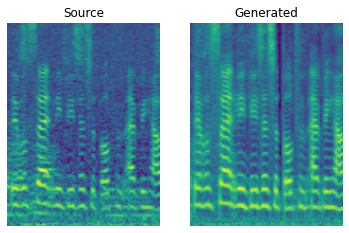

Mean D loss: 0.7290641069412231 Mean G loss: 0.31171298027038574 Mean ID loss: 0.062241654843091965
[Epoch 1/5000] [Batch 0] [D loss f: 0.7136263251304626 r: 0.6773574948310852] [G loss: 0.27480483055114746] [ID loss: 0.062022071331739426] [LR: 0.0002]
[Epoch 1/5000] [Batch 100] [D loss f: 0.6021251082420349 r: 0.6772367358207703] [G loss: 0.43146514892578125] [ID loss: 0.06400366127490997] [LR: 0.0002]
[Epoch 1/5000] [Batch 200] [D loss f: 0.6376940011978149 r: 0.7022939324378967] [G loss: 0.42731326818466187] [ID loss: 0.0626491978764534] [LR: 0.0002]
[Epoch 1/5000] [Batch 300] [D loss f: 0.7368905544281006 r: 0.7283180952072144] [G loss: 0.25926560163497925] [ID loss: 0.06268901377916336] [LR: 0.0002]
[Epoch 1/5000] [Batch 400] [D loss f: 0.7528221011161804 r: 0.6761616468429565] [G loss: 0.2822514474391937] [ID loss: 0.062284622341394424] [LR: 0.0002]
[Epoch 1/5000] [Batch 500] [D loss f: 0.7669481039047241 r: 0.6895999312400818] [G loss: 0.22508524358272552] [ID loss: 0.0625453293

  2%|▎         | 50/2000 [00:00<00:04, 392.84it/s, loss=0.00276, spectral_convergence=-7.4] 

(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 402.41it/s, loss=0.000431, spectral_convergence=-30.8]


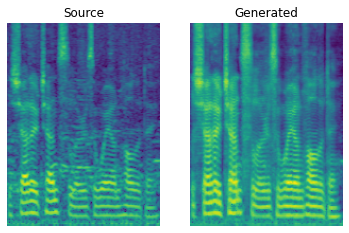

Mean D loss: 0.7305454015731812 Mean G loss: 0.309701532125473 Mean ID loss: 0.06227840110659599
[Epoch 2/5000] [Batch 0] [D loss f: 0.7396717071533203 r: 0.6512689590454102] [G loss: 0.3511110246181488] [ID loss: 0.06215852126479149] [LR: 0.0002]
[Epoch 2/5000] [Batch 100] [D loss f: 0.592694103717804 r: 0.6764810681343079] [G loss: 0.4119682312011719] [ID loss: 0.06322774291038513] [LR: 0.0002]
[Epoch 2/5000] [Batch 200] [D loss f: 0.6452903747558594 r: 0.7187572717666626] [G loss: 0.38961753249168396] [ID loss: 0.06284945458173752] [LR: 0.0002]
[Epoch 2/5000] [Batch 300] [D loss f: 0.7159119248390198 r: 0.7455927133560181] [G loss: 0.33408236503601074] [ID loss: 0.062326811254024506] [LR: 0.0002]
[Epoch 2/5000] [Batch 400] [D loss f: 0.7398343086242676 r: 0.6786090135574341] [G loss: 0.3162173628807068] [ID loss: 0.06224802881479263] [LR: 0.0002]
[Epoch 2/5000] [Batch 500] [D loss f: 0.7637222409248352 r: 0.7005193829536438] [G loss: 0.2854534089565277] [ID loss: 0.06246084347367287

  2%|▎         | 50/2000 [00:00<00:05, 379.01it/s, loss=0.00171, spectral_convergence=-8.89]

(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 400.28it/s, loss=4.84e-5, spectral_convergence=-37.3]


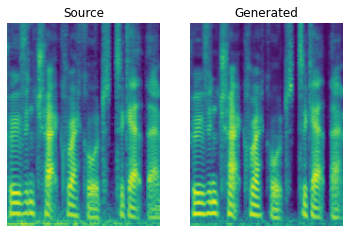

Mean D loss: 0.7311662435531616 Mean G loss: 0.3088901937007904 Mean ID loss: 0.062182892113924026
[Epoch 3/5000] [Batch 0] [D loss f: 0.7480156421661377 r: 0.660060703754425] [G loss: 0.28016865253448486] [ID loss: 0.06175891309976578] [LR: 0.0002]
[Epoch 3/5000] [Batch 100] [D loss f: 0.6159399747848511 r: 0.6524208784103394] [G loss: 0.4287915825843811] [ID loss: 0.06461931020021439] [LR: 0.0002]
[Epoch 3/5000] [Batch 200] [D loss f: 0.6354226469993591 r: 0.7048898935317993] [G loss: 0.36558759212493896] [ID loss: 0.06347133964300156] [LR: 0.0002]
[Epoch 3/5000] [Batch 300] [D loss f: 0.7359216809272766 r: 0.7204179167747498] [G loss: 0.2971074879169464] [ID loss: 0.06255660951137543] [LR: 0.0002]
[Epoch 3/5000] [Batch 400] [D loss f: 0.747058093547821 r: 0.6922343373298645] [G loss: 0.2986616790294647] [ID loss: 0.06258486956357956] [LR: 0.0002]
[Epoch 3/5000] [Batch 500] [D loss f: 0.7692105174064636 r: 0.6901951432228088] [G loss: 0.2700135409832001] [ID loss: 0.06217212975025177

  2%|▎         | 50/2000 [00:00<00:05, 387.39it/s, loss=0.00322, spectral_convergence=-6.75]

(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 401.12it/s, loss=0.00112, spectral_convergence=-20.4]


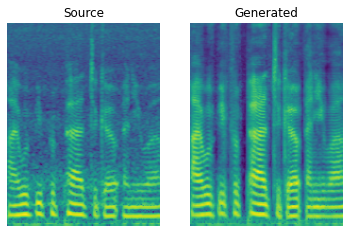

Mean D loss: 0.7308228015899658 Mean G loss: 0.3121732175350189 Mean ID loss: 0.06218554079532623
[Epoch 4/5000] [Batch 0] [D loss f: 0.7169482707977295 r: 0.6747213006019592] [G loss: 0.33491164445877075] [ID loss: 0.061578840017318726] [LR: 0.0002]
[Epoch 4/5000] [Batch 100] [D loss f: 0.6105496883392334 r: 0.6587590575218201] [G loss: 0.4246925413608551] [ID loss: 0.06343285739421844] [LR: 0.0002]
[Epoch 4/5000] [Batch 200] [D loss f: 0.6419187188148499 r: 0.7108738422393799] [G loss: 0.3964170813560486] [ID loss: 0.06343162804841995] [LR: 0.0002]
[Epoch 4/5000] [Batch 300] [D loss f: 0.7288317680358887 r: 0.7320982217788696] [G loss: 0.31554141640663147] [ID loss: 0.06243961304426193] [LR: 0.0002]
[Epoch 4/5000] [Batch 400] [D loss f: 0.738033652305603 r: 0.7033987641334534] [G loss: 0.3339269757270813] [ID loss: 0.062009260058403015] [LR: 0.0002]
[Epoch 4/5000] [Batch 500] [D loss f: 0.7596672177314758 r: 0.6899499297142029] [G loss: 0.2401016354560852] [ID loss: 0.062117706984281

  2%|▎         | 50/2000 [00:00<00:05, 382.49it/s, loss=0.000363, spectral_convergence=-9.42]

(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 402.74it/s, loss=0.000136, spectral_convergence=-40.1]


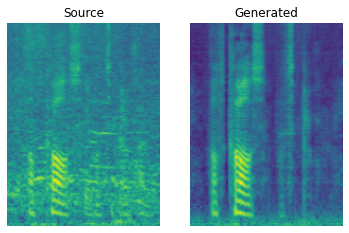

Mean D loss: 0.7313011884689331 Mean G loss: 0.3084513247013092 Mean ID loss: 0.06216934695839882
[Epoch 5/5000] [Batch 0] [D loss f: 0.7303016185760498 r: 0.6564087867736816] [G loss: 0.2981714606285095] [ID loss: 0.061633553355932236] [LR: 0.0002]
[Epoch 5/5000] [Batch 100] [D loss f: 0.6303052306175232 r: 0.6659554839134216] [G loss: 0.49242153763771057] [ID loss: 0.06356772780418396] [LR: 0.0002]
[Epoch 5/5000] [Batch 200] [D loss f: 0.653649091720581 r: 0.7034760117530823] [G loss: 0.4009946882724762] [ID loss: 0.06287224590778351] [LR: 0.0002]
[Epoch 5/5000] [Batch 300] [D loss f: 0.744402289390564 r: 0.7170913815498352] [G loss: 0.29556286334991455] [ID loss: 0.06259800493717194] [LR: 0.0002]
[Epoch 5/5000] [Batch 400] [D loss f: 0.7417596578598022 r: 0.6931418776512146] [G loss: 0.286050409078598] [ID loss: 0.06148086115717888] [LR: 0.0002]
[Epoch 5/5000] [Batch 500] [D loss f: 0.7461280226707458 r: 0.7186557650566101] [G loss: 0.3098611533641815] [ID loss: 0.06182427704334259]

  2%|▎         | 50/2000 [00:00<00:05, 378.00it/s, loss=0.00208, spectral_convergence=-5.79]

(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 403.64it/s, loss=0.000101, spectral_convergence=-44.1]


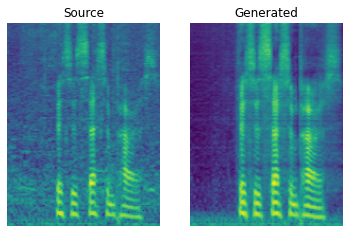

Mean D loss: 0.7321836948394775 Mean G loss: 0.30808812379837036 Mean ID loss: 0.06206619739532471
[Epoch 6/5000] [Batch 0] [D loss f: 0.7154196500778198 r: 0.6791644096374512] [G loss: 0.2751140296459198] [ID loss: 0.06201045215129852] [LR: 0.0002]
[Epoch 6/5000] [Batch 100] [D loss f: 0.6123791933059692 r: 0.6408568024635315] [G loss: 0.40718019008636475] [ID loss: 0.06378800421953201] [LR: 0.0002]
[Epoch 6/5000] [Batch 200] [D loss f: 0.6080189347267151 r: 0.7354783415794373] [G loss: 0.4141126573085785] [ID loss: 0.06343961507081985] [LR: 0.0002]
[Epoch 6/5000] [Batch 300] [D loss f: 0.7348172664642334 r: 0.7435487508773804] [G loss: 0.2839568257331848] [ID loss: 0.062432873994112015] [LR: 0.0002]
[Epoch 6/5000] [Batch 400] [D loss f: 0.7352374792098999 r: 0.7157344222068787] [G loss: 0.3043108284473419] [ID loss: 0.06217789649963379] [LR: 0.0002]
[Epoch 6/5000] [Batch 500] [D loss f: 0.7575252056121826 r: 0.7000593543052673] [G loss: 0.28082337975502014] [ID loss: 0.06236276775598

  2%|▎         | 50/2000 [00:00<00:05, 385.11it/s, loss=0.000509, spectral_convergence=-9.31]

(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 403.39it/s, loss=0.000114, spectral_convergence=-40.4]


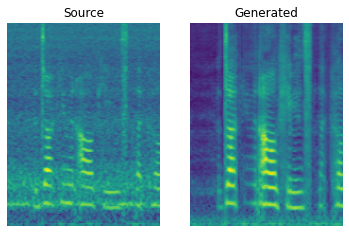

Mean D loss: 0.7326111197471619 Mean G loss: 0.3032835125923157 Mean ID loss: 0.06210365146398544
[Epoch 7/5000] [Batch 0] [D loss f: 0.7347005605697632 r: 0.6738619804382324] [G loss: 0.32868820428848267] [ID loss: 0.06166202947497368] [LR: 0.0002]
[Epoch 7/5000] [Batch 100] [D loss f: 0.6290803551673889 r: 0.6641067266464233] [G loss: 0.37504154443740845] [ID loss: 0.06419260054826736] [LR: 0.0002]
[Epoch 7/5000] [Batch 200] [D loss f: 0.6393090486526489 r: 0.7021461725234985] [G loss: 0.35055938363075256] [ID loss: 0.06241142749786377] [LR: 0.0002]
[Epoch 7/5000] [Batch 300] [D loss f: 0.717743456363678 r: 0.7381014823913574] [G loss: 0.31882619857788086] [ID loss: 0.062162093818187714] [LR: 0.0002]
[Epoch 7/5000] [Batch 400] [D loss f: 0.7349079251289368 r: 0.6969584822654724] [G loss: 0.34127646684646606] [ID loss: 0.06264126300811768] [LR: 0.0002]
[Epoch 7/5000] [Batch 500] [D loss f: 0.7790262699127197 r: 0.6766847968101501] [G loss: 0.2808518707752228] [ID loss: 0.0620157383382

100%|██████████| 2000/2000 [00:05<00:00, 392.57it/s, loss=0.000663, spectral_convergence=-26.7]


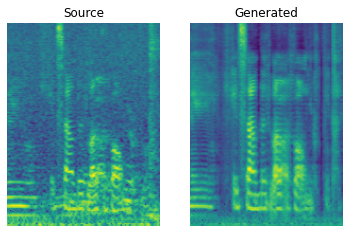

Mean D loss: 0.733918309211731 Mean G loss: 0.305122047662735 Mean ID loss: 0.062013838440179825
[Epoch 8/5000] [Batch 0] [D loss f: 0.7284316420555115 r: 0.6602253913879395] [G loss: 0.3184219002723694] [ID loss: 0.06161757558584213] [LR: 0.0002]
[Epoch 8/5000] [Batch 100] [D loss f: 0.6118923425674438 r: 0.6772513389587402] [G loss: 0.49234285950660706] [ID loss: 0.06325539946556091] [LR: 0.0002]
[Epoch 8/5000] [Batch 200] [D loss f: 0.6262869238853455 r: 0.7197522521018982] [G loss: 0.3668988049030304] [ID loss: 0.06305712461471558] [LR: 0.0002]
[Epoch 8/5000] [Batch 300] [D loss f: 0.7497040629386902 r: 0.744590699672699] [G loss: 0.2537382245063782] [ID loss: 0.06195040047168732] [LR: 0.0002]
[Epoch 8/5000] [Batch 400] [D loss f: 0.7350209951400757 r: 0.6992201805114746] [G loss: 0.31641140580177307] [ID loss: 0.06213315576314926] [LR: 0.0002]
[Epoch 8/5000] [Batch 500] [D loss f: 0.7517937421798706 r: 0.7081366181373596] [G loss: 0.3235079050064087] [ID loss: 0.06210726127028465]

  3%|▎         | 60/2000 [00:00<00:04, 413.10it/s, loss=0.00193, spectral_convergence=-8.85]

(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 408.81it/s, loss=0.000155, spectral_convergence=-44.1]


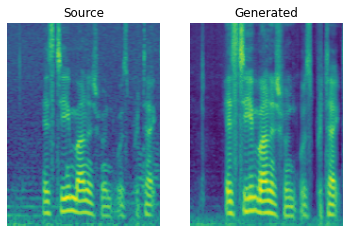

Mean D loss: 0.7326822280883789 Mean G loss: 0.3048873245716095 Mean ID loss: 0.061955858021974564
[Epoch 9/5000] [Batch 0] [D loss f: 0.7411602735519409 r: 0.6605265736579895] [G loss: 0.25130224227905273] [ID loss: 0.06217128410935402] [LR: 0.0002]
[Epoch 9/5000] [Batch 100] [D loss f: 0.6160283088684082 r: 0.6670584082603455] [G loss: 0.4539092779159546] [ID loss: 0.06399867683649063] [LR: 0.0002]
[Epoch 9/5000] [Batch 200] [D loss f: 0.6588173508644104 r: 0.6809425354003906] [G loss: 0.386627197265625] [ID loss: 0.06273303180932999] [LR: 0.0002]
[Epoch 9/5000] [Batch 300] [D loss f: 0.7323834896087646 r: 0.7465075850486755] [G loss: 0.32836422324180603] [ID loss: 0.062205009162425995] [LR: 0.0002]
[Epoch 9/5000] [Batch 400] [D loss f: 0.7450408339500427 r: 0.6846113801002502] [G loss: 0.31816157698631287] [ID loss: 0.06236829608678818] [LR: 0.0002]
[Epoch 9/5000] [Batch 500] [D loss f: 0.7513954043388367 r: 0.7178804278373718] [G loss: 0.26959311962127686] [ID loss: 0.0614703148603

  2%|▎         | 50/2000 [00:00<00:05, 386.76it/s, loss=0.0015, spectral_convergence=-9.14] 

(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 409.42it/s, loss=0.000263, spectral_convergence=-26.3]


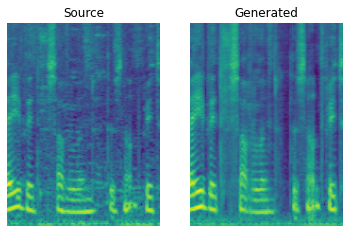

Mean D loss: 0.7320714592933655 Mean G loss: 0.3068080246448517 Mean ID loss: 0.061973392963409424
[Epoch 10/5000] [Batch 0] [D loss f: 0.7084181308746338 r: 0.6907439231872559] [G loss: 0.3148398995399475] [ID loss: 0.06194504350423813] [LR: 0.0002]
[Epoch 10/5000] [Batch 100] [D loss f: 0.616507887840271 r: 0.6632850170135498] [G loss: 0.37503886222839355] [ID loss: 0.0636756643652916] [LR: 0.0002]
[Epoch 10/5000] [Batch 200] [D loss f: 0.6444148421287537 r: 0.7079431414604187] [G loss: 0.4261733889579773] [ID loss: 0.06414768099784851] [LR: 0.0002]
[Epoch 10/5000] [Batch 300] [D loss f: 0.7400742173194885 r: 0.7352895140647888] [G loss: 0.2842811644077301] [ID loss: 0.06264683604240417] [LR: 0.0002]
[Epoch 10/5000] [Batch 400] [D loss f: 0.7501797676086426 r: 0.684506893157959] [G loss: 0.289601594209671] [ID loss: 0.06178072839975357] [LR: 0.0002]
[Epoch 10/5000] [Batch 500] [D loss f: 0.760200560092926 r: 0.7077025771141052] [G loss: 0.27714303135871887] [ID loss: 0.06164220720529

100%|██████████| 2000/2000 [00:04<00:00, 414.55it/s, loss=0.000484, spectral_convergence=-28.3]


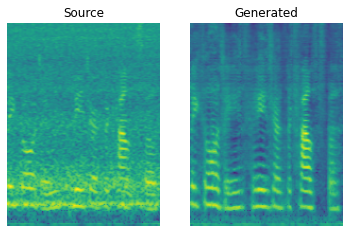

Mean D loss: 0.7320604920387268 Mean G loss: 0.3048880398273468 Mean ID loss: 0.06197161227464676
[Epoch 11/5000] [Batch 0] [D loss f: 0.7122842669487 r: 0.6969263553619385] [G loss: 0.3791833519935608] [ID loss: 0.06124451011419296] [LR: 0.0002]
[Epoch 11/5000] [Batch 100] [D loss f: 0.6072472929954529 r: 0.6774104833602905] [G loss: 0.4596315622329712] [ID loss: 0.06306004524230957] [LR: 0.0002]
[Epoch 11/5000] [Batch 200] [D loss f: 0.6556366086006165 r: 0.6980297565460205] [G loss: 0.39522141218185425] [ID loss: 0.06254848092794418] [LR: 0.0002]
[Epoch 11/5000] [Batch 300] [D loss f: 0.7262786030769348 r: 0.7414640188217163] [G loss: 0.32763493061065674] [ID loss: 0.06220751255750656] [LR: 0.0002]
[Epoch 11/5000] [Batch 400] [D loss f: 0.751446008682251 r: 0.6863334774971008] [G loss: 0.2608756124973297] [ID loss: 0.06211261823773384] [LR: 0.0002]
[Epoch 11/5000] [Batch 500] [D loss f: 0.7584431171417236 r: 0.7012961506843567] [G loss: 0.2632375657558441] [ID loss: 0.06151642277836

  0%|          | 0/2000 [00:00<?, ?it/s]

(5, 192, 24, 1)


100%|██████████| 2000/2000 [00:05<00:00, 380.32it/s, loss=0.000148, spectral_convergence=-39.1]


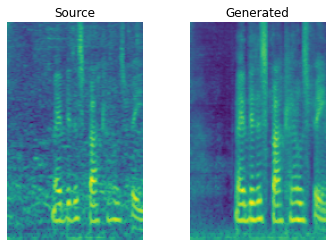

Mean D loss: 0.7327914237976074 Mean G loss: 0.3056010901927948 Mean ID loss: 0.061922598630189896
[Epoch 12/5000] [Batch 0] [D loss f: 0.7424541711807251 r: 0.6642330884933472] [G loss: 0.2356584370136261] [ID loss: 0.06164541468024254] [LR: 0.0002]
[Epoch 12/5000] [Batch 100] [D loss f: 0.6208915710449219 r: 0.654977560043335] [G loss: 0.37161678075790405] [ID loss: 0.06412029266357422] [LR: 0.0002]
[Epoch 12/5000] [Batch 200] [D loss f: 0.6343365907669067 r: 0.7159728407859802] [G loss: 0.41369959712028503] [ID loss: 0.06349235028028488] [LR: 0.0002]
[Epoch 12/5000] [Batch 300] [D loss f: 0.7418944835662842 r: 0.7429360747337341] [G loss: 0.2912070155143738] [ID loss: 0.06196417659521103] [LR: 0.0002]
[Epoch 12/5000] [Batch 400] [D loss f: 0.7476064562797546 r: 0.6898221373558044] [G loss: 0.2874249517917633] [ID loss: 0.06252618134021759] [LR: 0.0002]
[Epoch 12/5000] [Batch 500] [D loss f: 0.717253565788269 r: 0.7287853956222534] [G loss: 0.34432244300842285] [ID loss: 0.0615231692

  2%|▎         | 50/2000 [00:00<00:05, 355.41it/s, loss=0.00335, spectral_convergence=-5.3]

(6, 192, 24, 1)


100%|██████████| 2000/2000 [00:04<00:00, 406.02it/s, loss=0.000143, spectral_convergence=-36.2]


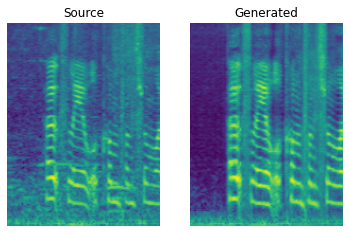

Mean D loss: 0.7338992953300476 Mean G loss: 0.30275997519493103 Mean ID loss: 0.061870306730270386
[Epoch 13/5000] [Batch 0] [D loss f: 0.729812741279602 r: 0.6705519556999207] [G loss: 0.2328481823205948] [ID loss: 0.06170633062720299] [LR: 0.0002]
[Epoch 13/5000] [Batch 100] [D loss f: 0.5928261280059814 r: 0.6801769733428955] [G loss: 0.39322325587272644] [ID loss: 0.06454441696405411] [LR: 0.0002]
[Epoch 13/5000] [Batch 200] [D loss f: 0.6336172819137573 r: 0.703762948513031] [G loss: 0.4571704566478729] [ID loss: 0.06281746923923492] [LR: 0.0002]
[Epoch 13/5000] [Batch 300] [D loss f: 0.7532749176025391 r: 0.7333866953849792] [G loss: 0.304120272397995] [ID loss: 0.06211875006556511] [LR: 0.0002]
[Epoch 13/5000] [Batch 400] [D loss f: 0.7438251972198486 r: 0.6862408518791199] [G loss: 0.2868557870388031] [ID loss: 0.061947766691446304] [LR: 0.0002]
[Epoch 13/5000] [Batch 500] [D loss f: 0.76971036195755 r: 0.6841163039207458] [G loss: 0.2959996163845062] [ID loss: 0.0619053393602

In [ ]:
#Training


#train(5000, batch_size=bs, lr=0.0002, n_save=1, gupt=3) 

In [ ]:
#After Training, RESULTS

#Generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  dsa.append(imlast)
  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path='../content/', show=True):
  specarr = chopspec(spec)
  print(specarr.shape)
  a = specarr
  print('Generating...')
  ab = gen(a, training=True)
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec)
  awv = deprep(a)
  abwv = deprep(ab)
  print('Saving...')
  pathfin = f'{path}/{name}'
  os.mkdir(pathfin)
  sf.write(pathfin+'/AB.wav', abwv, sr)
  sf.write(pathfin+'/A.wav', awv, sr)
  print('Saved WAV!')
  print('INPUT')
  IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  print('GENERATED')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()
  return abwv

(27456,)


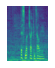

(7, 192, 24, 1)
Generating...


  0%|          | 0/2000 [00:00<?, ?it/s]

Assembling and Converting...


100%|██████████| 2000/2000 [00:03<00:00, 654.60it/s, loss=0.00221, spectral_convergence=-11.1]


Saving...
Saved WAV!
INPUT


GENERATED


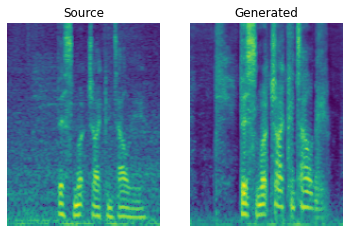

In [ ]:
#Wav to wav conversion

wv, sr = librosa.load("/content/drive/My Drive/download (42).wav", sr=16000)  #Load waveform
print(wv.shape)
speca = prep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='FILENAME13', path='../content/')           #Convert and save wav

In [ ]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
pip install pydub

In [ ]:
from pydub import AudioSegment
# 
path = "/content/noisy/"
path1="/content/p232_01112.wav"
# Read the audio file 
song = AudioSegment.from_file(path,'wav').set_frame_rate(16000)
# Export the.
song.export(path, format='wav', bitrate='32k')

#sf.write(path1, song, 16000)

IsADirectoryError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
from pydub import AudioSegment
path="/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/"
l=os.listdir(path)
cnt=0
for j in l:
  name=path+j
  #path=os.path.join(path,"p257_"+p+".wav")
  song = AudioSegment.from_file(name,'wav').set_frame_rate(16000)
  # Export the file to the specified path by bitrate of 32k, here is to directly overwrite the original file.
  song.export(name, format='wav', bitrate='32k')
  print(name)
  cnt+=1
  print(cnt)

Streaming output truncated to the last 5000 lines.
9073
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_157.wav
9074
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_165.wav
9075
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_158.wav
9076
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_153.wav
9077
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_146.wav
9078
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_163.wav
9079
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_145.wav
9080
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_177.wav
9081
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_175.wav
9082
/content/drive/My Drive/clean_trainset_28spk_wav/clean_trainset_28spk_wav/p231_169.wav
9083
/content/drive/My Drive/

In [ ]:
import numpy as np
np.shape(l)

(11572,)